<h1 style="font-size: 40px">Parametric Value at Risk and Expected Shortfall</h1>

<h2 style="font-size:30px"><ins>THEORY</ins></h2> The Value at Risk(VaR) for a given asset/investment is a statistical measure of the risk of loss that an investor is exposed to. It estimates, as a percentage of the asset value, the potential losses an investor could incur over a given period of time, with a given degree of confidence. For example, one might say that the Value at Risk on a stock over the course of a month is 5% with a 68% confidence level. Loosely speaking, this means that there's a 68% chance that the stock will fall(at most) by 5%. Raising the confidence level leads to a higher VaR, whereas lowering it has the opposite effect. Value of Risk is an important metric for a financial institution's internal controls as well as external regulations.

<h2>Calculating VaR</h2>
One of the most common ways to calculate Value at Risk is to collect historical data on asset returns and fit it to a standard distribution. The parameters of the distribution can then help quantify the VaR, usually by means of a percentile score. The normal distribution is often chosen for this purpose, but it is known<a href="#ref1"><sup>[1]</sup></a>. that Student's t-distribution sometimes provides better estimates of risk, especially when the histogram of returns is fat-tailed. In such cases, the normal distribution fails to adequately capture potential losses at higher confidence levels, leading to an underestimation of risk. The figure below illustrates the situation using synthetic data.

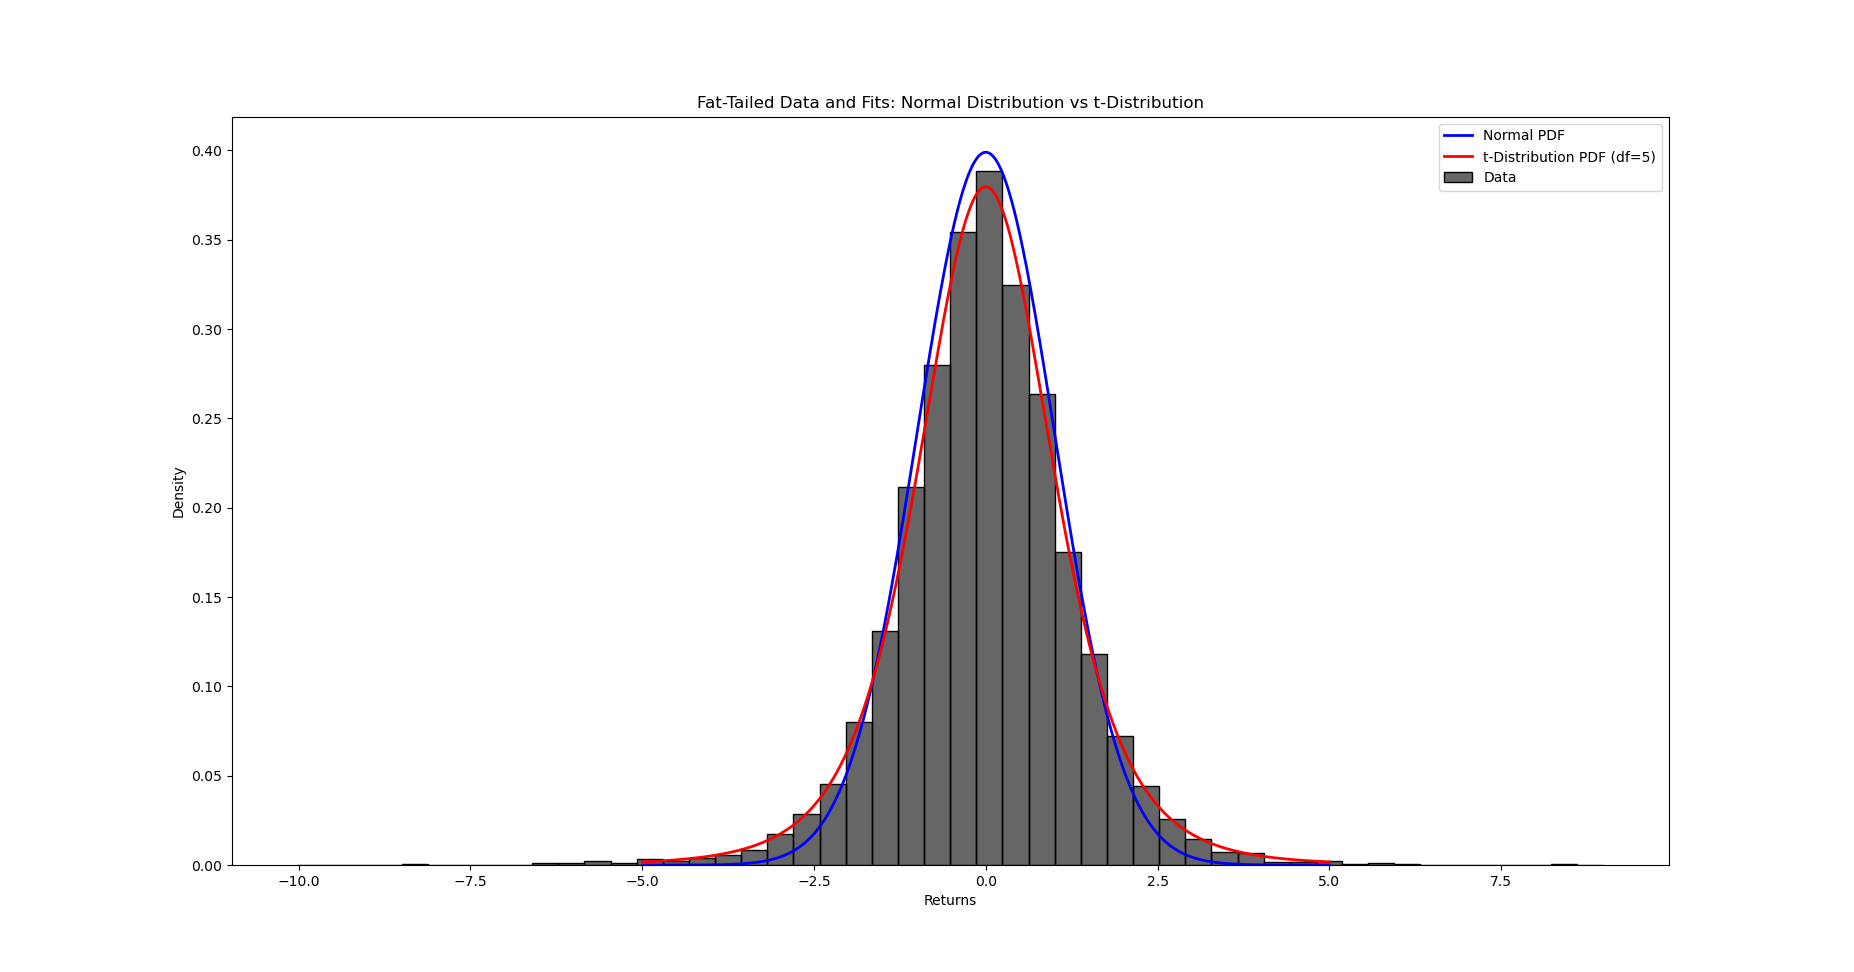

<h3>Normal Distribution</h3>
A random variable is said to be normally distributed if it has the following probability density:
$$
f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\left( \frac{x-\mu}{\sqrt{2} \sigma}\right)^2}
$$
As such, a normal distribution is completely determined by two parameters: its mean $\mu$ and its variance $\sigma$. Assuming that asset returns are normally distributed, the Value at Risk is given by the formula<a href="#ref1"><sup>[1]</sup></a>
$$
\begin{equation}
\text{VaR}_n = \mu - z_{\alpha} \sigma \tag{1}
\end{equation}
$$
where $\mu$ and $\sigma$ are the mean and standard deviation of the underlying data, respectively. The number $z_\alpha$ is the z-score(distance from the mean as a multiple of $\sigma$) at a confidence interval of $\alpha$(see fig. below):

$$
z_\alpha = \frac{x-\mu}{\sigma}
$$

Some authors use a different convention and write $\text{VaR}_n = \mu + z_{1-\alpha} \sigma$ instead, but both definitions are equivalent.

For normal distributions, it is also straightforward to calculate another metric called Expected Shortfall, which is the area beyond the VaR line. In the figure below, if the positive percentile Value at Risk is represented by the green line, the area under the curve beyond the green line is the Expected Shortfall. For normal distributions, it is given by  
$$
\text{ES}_n = \mu - \sigma \frac{\phi(z_{\alpha})}{1 - \alpha}
$$

where $\phi$ is the probability distribution function of the standard normal distribuion.

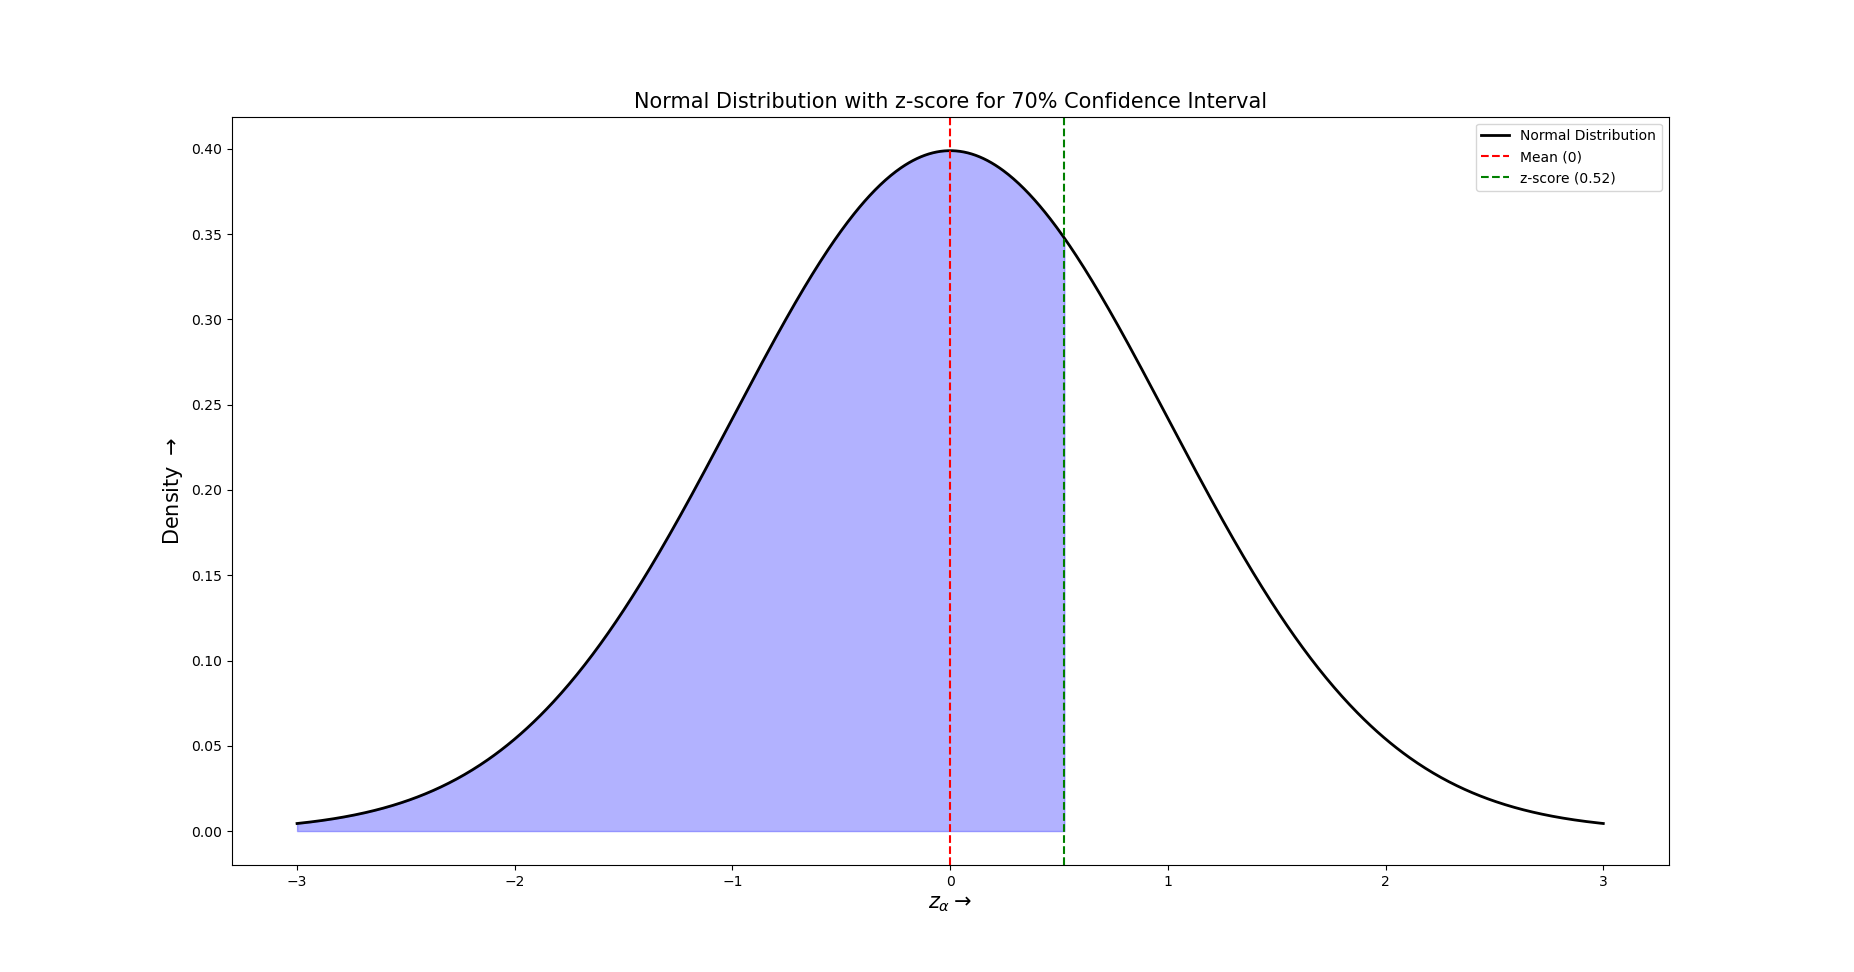

<h3>Student's t-distribution</h3>
The probability density function of the t-distribution is given by:
$$
f(x) = \frac{\Gamma(0.5(\nu + 1))}{\Gamma(0.5\nu) \sqrt{\pi \nu \beta}} \left[1 + \frac{(x-\mu)^2}{\nu \beta}\right]^{-0.5(1+\nu)}
$$
where $\nu$ is the key parameter, called the degree(s) of freedom. Its shape resembles that of a Gaussian, with a lower peak and fatter tails. In the limit $\nu \to \infty$, the t-distribution tends to the normal distribution. The Value at Risk for data obeying the t-distribution is given by<a href="#ref1"><sup>[1]</sup></a>
$$
\begin{equation}
\text{VaR}_t = \mu - t_{\alpha,\nu} \sqrt{\beta}
\end{equation}
$$
where $t_{\alpha,\nu}$ is similar to the z-score mentioned above:
$$
t_{\alpha,\nu} = \frac{x-\mu}{\sqrt{\beta}}
$$
If $\mu$ is the mean of the stock returns data and $\sigma$ its variance, we have:
$$
\beta = \sigma^2 \left (\frac{3 + \kappa}{3 + 2 \kappa} \right)
$$
where $\kappa=6/(\nu-4)$.

For the expected shortfall, we have:

$$
\text{ES}_t = \mu + \sqrt{\beta} \cdot \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi \nu} \cdot \Gamma\left(\frac{\nu}{2}\right) \cdot \alpha} \cdot \left(1 + \frac{t_{\alpha,\nu}^2}{\nu} \right)^{-\frac{\nu - 1}{2}}
$$

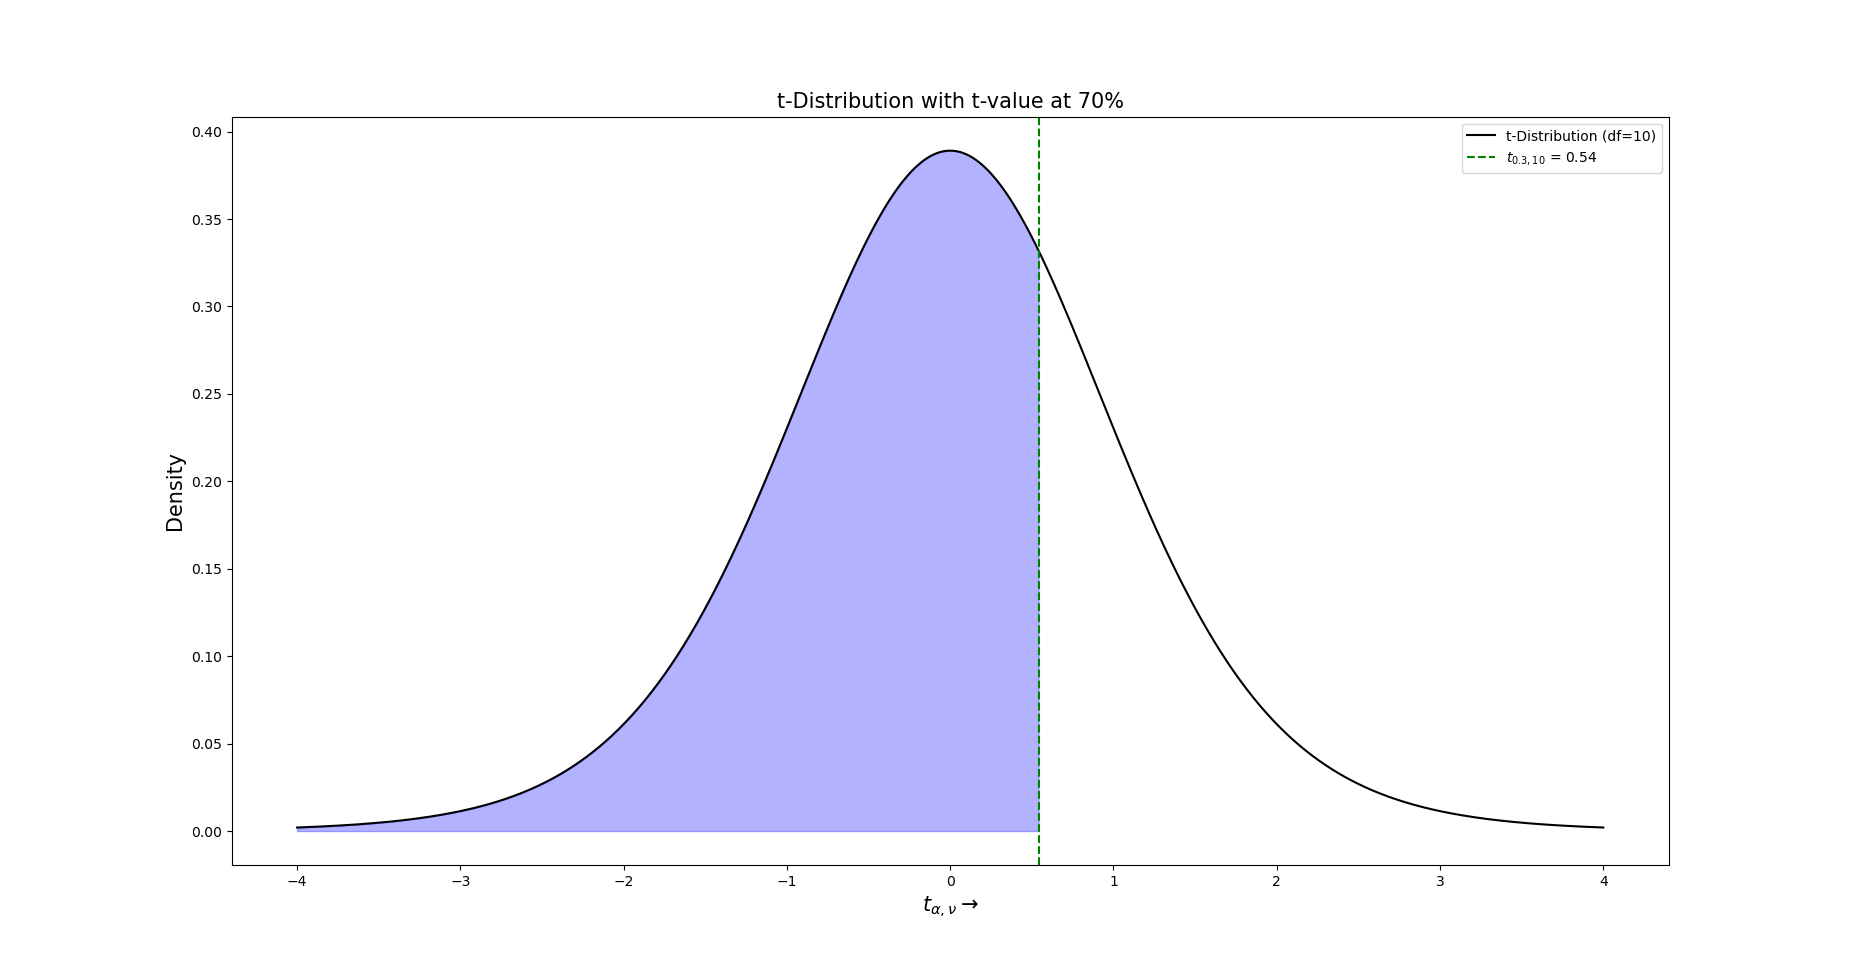

<h3>Monte Carlo simulations of Distributions</h3>

Although fitting the data to a distribution is a straightforward way to calculate the Value at Risk of historical returns, Monte Carlo simulations offer the possibility to model counterfactual outcomes with alternate parameters. For example, they enable predictions on risk for returns with slightly different means, or a mean that varies on a rolling basis. This notebook includes an elementary application of Monte Carlo methods: simulating stock returns distributed normally with a fixed mean and variance(matching that of the input data), and calculating the VaR for a large number of runs. <a href = "https://github.com/praveer-kg/Finance_Public/blob/main/Risk%20Management/2.%20Asset%20Parameter%20Estimation%20and%20Market%20Risk%20with%20Merton%20Jump-Diffusion%20Model.ipynb">Notebook #2 </a> of this repository contains a more complex application with stochastic differential equations.

<h2 style="font-size:30px"><ins>CODE</ins></h2>
We begin by importing a few standard models that will be useful for the rest of this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import yfinance as yf
import pandas as pd
from scipy import special

<h3>Historical Method</h3>
The following function calculates the VaR and ES in Python by sampling the given returns data on a rolling n-day window. The inputs are the data to be fitted, the confidence level to calculate the VaR at, and the n-day period for which the VaR and ES are to be calculated.

In [2]:
def VaR_ES_Historical(portfolio_returns, confidence_level, n_days):
    n_day_returns = []
    for i in range(len(portfolio_returns) - n_days + 1):
        #sum the returns for n_days
        cumulative_returns = np.sum(portfolio_returns[i : i + n_days])
        n_day_returns.append(cumulative_returns)

    n_day_returns = np.array(n_day_returns)
    #sort the n-day returns
    sorted_returns = np.sort(n_day_returns)
    #calculate index for 5th %ile 
    var_index = int(np.floor((1 - confidence_level) * len(sorted_returns)))
    #get VaR
    VaR_h = sorted_returns[var_index]
    #calculate returns below VaR
    ES_returns = sorted_returns[sorted_returns < VaR_h]
    #get ES
    ES_h = np.mean(ES_returns)
    print(f"VaR = {100 * VaR_h:.4f}%, ES = {100 * ES_h:.4f}% -----Historical(t)")

    return VaR_h, ES_h

<h3> Normal Distribution</h3>
The following function calculates the VaR and ES by modelling n-day returns using the normal distribution. The inputs are the data to be fitted, the n-day period for which the VaR and ES are to be calculated, the confidence level to calculate the risk at, and an x-axis to later visualize the fit against.

In [3]:
#Value-at-Risk and Expected Shortfall using Normal dist.
def VaR_ES_Normal(portfolio_returns, confidence_level, n_days, x):
    #daily mean and standard deviation
    μ = np.mean(portfolio_returns)
    σ = np.std(portfolio_returns)

    #scale for n-days
    μ_n_days = μ * n_days
    σ_n_days = σ * np.sqrt(n_days)
    z_α = stats.norm.ppf(1 - confidence_level)
    
    VaR_n = μ_n_days + z_α * σ_n_days
    ES_n = μ_n_days - σ_n_days * (stats.norm.pdf(z_α) / (1 - confidence_level))
    
    fit_n_pdf = stats.norm.pdf(x, μ_n_days, σ_n_days)
    print(f"VaR = {100 * VaR_n:.4f}%, ES = {100 * ES_n:.4f}% \t-----Parametric(normal)")    
    results = VaR_n, fit_n_pdf, ES_n
    return results

<h3> Student's t-Distribution</h3>
Similarly, the following function calculates the VaR in Python using Student's t-distribution. The inputs are the same as before.

In [4]:
#Value-at-Risk and Expected Shortfall using the Student-t dist.
def VaR_ES_Student_t(portfolio_returns, confidence_level, n_days, x):
    #daily mean and std. dev.
    μ = np.mean(portfolio_returns)
    σ = np.std(portfolio_returns)
    ν = stats.t.fit(portfolio_returns)[0]

    #scale up mean for n-days
    μ_n_days = μ * n_days
    #calculate κ (excess kurtosis) and β
    κ = 6 / (ν - 4)
    β = σ**2 * ((3 + κ) / (3 + 2 * κ))
    β_n_days = β * n_days
    #calculate t_α,v 
    α = 1 - confidence_level
    t_α = stats.t.ppf(1 - α, df=ν)
    #calculate VaR
    VaR_t = μ_n_days - t_α * np.sqrt(β_n_days)
    
    #calculate ES
    gamma_numerator = special.gamma((ν + 1) / 2)
    gamma_denominator = np.sqrt(np.pi * ν) * special.gamma(ν / 2) * α

    ES_t = μ_n_days + np.sqrt(β_n_days) * (gamma_numerator / gamma_denominator) * ((1 + t_α**2 / ν)**(-(ν - 1) / 2))
    ES_t = -ES_t
    fit_t_pdf = stats.t.pdf(x, ν, loc=μ_n_days, scale=np.sqrt(β_n_days))
    print(f"VaR = {100 * VaR_t:.4f}%, ES = {100 * ES_t:.4f}% -----Parametric(t)")

    results = VaR_t, fit_t_pdf, ES_t
    return results

<h3>Mone Carlo with Normal Distribution</h3>
Finally, the function below calculates n-day returns by simulating daily returns under the assumption of normality. It outputs the VaR, ES, and a distribution axis(which we will use to visualize fits for the parametric methods) for a set of simulations. 

In [5]:
#Value-at-Risk and Expected Shortfall using Monte Carlo simulations(assume normally distributed n-day returns)
def VaR_ES_MC(portfolio_returns,n_runs,confidence_level,n_days):
   
   μ = np.mean(portfolio_returns)
   σ = np.std(portfolio_returns)
   #simulate returns for n_days
   daily_simulated_returns = np.random.normal(μ, σ, (n_runs, n_days))
   #calculate returns after n_days
   cumulative_returns = np.sum(daily_simulated_returns, axis=1)

   α = 1 - confidence_level
   VaR_mc = np.percentile(cumulative_returns, 100 * α)
   
   μ_sim_cum = np.mean(cumulative_returns)
   std_sim_cum = np.std(cumulative_returns)
   x = np.linspace(min(cumulative_returns), max(cumulative_returns), 100)
   fit_mc_pdf = stats.norm.pdf(x, μ_sim_cum, std_sim_cum)
   ES_mc = np.mean(cumulative_returns[cumulative_returns <= VaR_mc])
   print(f"VaR = {100 * VaR_mc:.4f}%, ES = {100 * ES_mc:.4f}% \t-----Monte Carlo(normal)")

   results = VaR_mc, fit_mc_pdf, ES_mc, cumulative_returns,x
   return results

Before we apply these function, we will first define two others to visualize the final results.

In [6]:
def plot_all_returns(returns):
    plt.figure(figsize=(10, 6))
    for clmn in returns.columns:
        sns.histplot(returns[clmn], bins=50, alpha=0.5, label=clmn)
    plt.title("Individual Stock Returns")
    plt.xlabel("Returns(%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def plot_portfolio_returns(portfolio_returns,VaR,ES,fits,confidence_level,n_days,x):
    VaR_h,VaR_n,VaR_t,VaR_mc = VaR
    VaR_h,ES_n,ES_t,ES_mc = ES

    fit_n,fit_t,fit_mc = fits
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(portfolio_returns, bins=50, stat='density',color="black", alpha=0.6, label="Portfolio Returns")
    
    ax.plot(x, fit_n, 'r-', label="Normal Fit")
    ax.plot(x, fit_t, 'b-', label="Student Fit")
    ax.plot(x, fit_mc, 'g-', label="MC Normal Fit")
    #show VaR
    ax.axvline(VaR_n, color='goldenrod', linestyle='dashed', linewidth=2, label=f'VaR_h ({VaR_h:.3f})')
    ax.axvline(VaR_n, color='red', linestyle='dashed', linewidth=2, label=f'VaR_n ({VaR_n:.3f})')
    ax.axvline(VaR_t, color='blue', linestyle='dashed', linewidth=2, label=f'VaR_t ({VaR_t:.3f})')
    ax.axvline(VaR_mc, color='green', linestyle='dashed', linewidth=2, label=f'VaR_mc ({VaR_mc:.3f})')
    #show ES
    ax.axvline(ES_h, color='goldenrod', linestyle='dashed', linewidth=2, label=f'ES_h ({ES_h:.3f})')
    ax.axvline(ES_n, color='red', linestyle='dotted', linewidth=2, label=f'ES_n ({ES_n:.3f})')
    ax.axvline(ES_t, color='blue', linestyle='dotted', linewidth=2, label=f'ES_t ({ES_t:.3f})')
    ax.axvline(ES_mc, color='green', linestyle='dotted', linewidth=2, label=f'ES_mc ({ES_mc:.3f})')
    #title plot
    ax.set_title(f"Simulated {n_days}-day Portfolio Returns with Fits and VaR at {100*confidence_level}%")
    ax.set_xlabel("ln(Returns)")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

The main function below collects historical daily returns for a few tickers using $\texttt{yfinance}$ and implements all four methods to calculate the Value at Risk and Expected Shortfall for a portfolio of stocks.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed




Value at Risk and Expected Shortfall for 10-day horizon at 95.0%

VaR = -6.5736%, ES = -8.8902% -----Historical(t)
VaR = -6.8532%, ES = -8.7613% 	-----Monte Carlo(normal)
VaR = -6.7470%, ES = -8.7960% 	-----Parametric(normal)
VaR = -6.4581%, ES = -10.3551% -----Parametric(t)


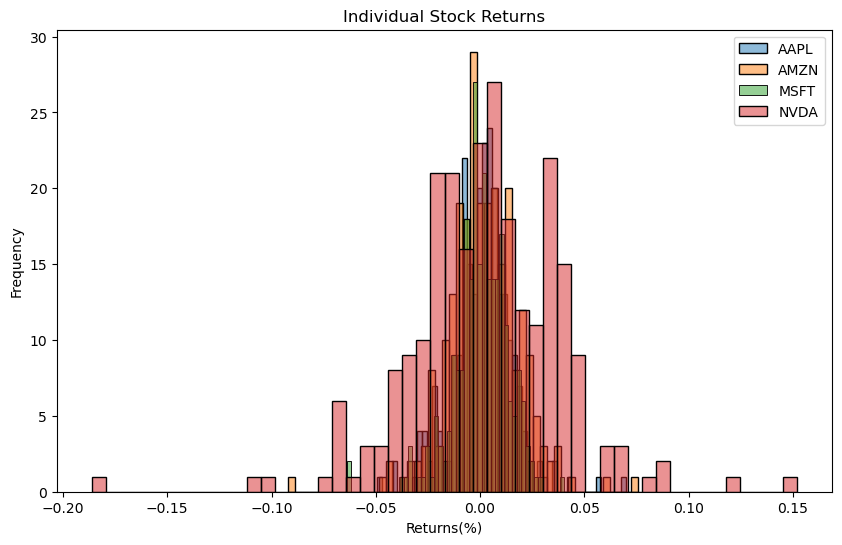

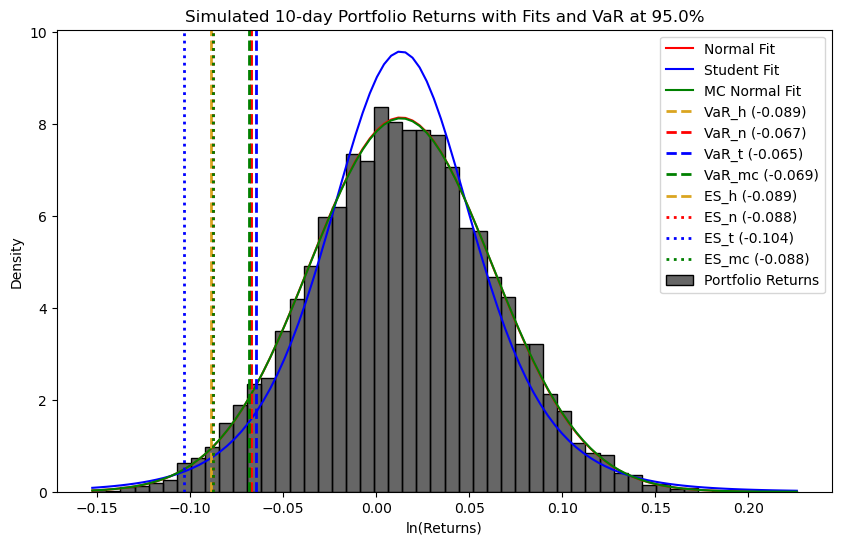

In [7]:
if __name__=="__main__":
    
    tickers = ["AMZN","MSFT","AAPL","NVDA"]    #choose portfolio of stocks
    confidence_level=0.95                      #set confidence level for VaR
    
    start =pd.Timestamp(2024,2,1)
    stop = pd.Timestamp(2025,2,1)
    
    data = yf.download(tickers, start, stop)   #download data
    weights = np.array([1/len(tickers) for i in range(len(tickers))])
    
    close_prices = data["Close"]
    logreturns = np.log(close_prices / close_prices.shift(1)).dropna()
    portfolio_returns = np.dot(logreturns,weights)
    
    n_runs = 10000                             #num. of runs for Monte-Carlo function 
    n_days = 10                                #VaR/ES horizon
    
    print(f"\n\nValue at Risk and Expected Shortfall for {n_days}-day horizon at {100*confidence_level}%\n")
    VaR_h,ES_h = VaR_ES_Historical(portfolio_returns, confidence_level, n_days)
    VaR_mc,fit_mc,ES_mc,sim_returns,x = VaR_ES_MC(portfolio_returns,n_runs,confidence_level,n_days)
    VaR_n,fit_n,ES_n= VaR_ES_Normal(portfolio_returns,confidence_level,n_days,x)
    VaR_t,fit_t,ES_t = VaR_ES_Student_t(portfolio_returns,confidence_level,n_days,x)
    VaR = [VaR_h,VaR_n,VaR_t,VaR_mc]
    ES = [ES_h,ES_n,ES_t,ES_mc]

    fits = (fit_n,fit_t,fit_mc)
    plot_all_returns(logreturns)
    plot_portfolio_returns(sim_returns,VaR,ES,fits,confidence_level,n_days,x)  


## References
<a id="ref1"></a>[1] Chu‐Hsiung Lin, Shan‐Shan Shen "<a href="https://www.emerald.com/insight/content/doi/10.1108/15265940610664960/full/html?skipTracking=true">*Can the student‐t distribution provide accurate value at risk?*</a>".  Journal of Risk Finance, ISSN: 1526-5943.